## Mount the google drive and then change the current directory

In [1]:
! ls

data  drive  nima  sample_data


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Create a data folder and then copy data to it
Copy the project code 

In [2]:
! mkdir data
! ls data
! cp -r /content/drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/AVA /content/data
! cp -r /content/drive/MyDrive/Colab\ Notebooks/img-quality-assesment/nima /content

^C


### Import the libraries
create some path variables

In [1]:
! pip install livelossplot modin[dask]

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import modin.pandas as pd
import seaborn as sns
import random
import sys

# PROJECT_PATH = '/content/' # for google colab
PROJECT_PATH = '/home/jovyan/work' # for local run
AVA_DIR = os.path.join(PROJECT_PATH,'DATA', 'AVA')
AVA_DATASET_DIR = os.path.join(AVA_DIR, 'images')
print(f'Adding project module {PROJECT_PATH}')
sys.path.append(PROJECT_PATH)

Perhaps you already have a cluster running?
Hosting the HTTP server on port 41929 instead


Adding project module /home/jovyan/work


In [3]:
from nima.utils.ava_preprocess import get_ava_csv_df, get_tags_df, get_rating_columns
from nima.model.model_builder import NIMA
from nima.model.loss import earth_movers_distance

In [56]:
ava_csv_df = get_ava_csv_df()
ratings_column = get_rating_columns()

tags_df = get_tags_df()
tags_dict = tags_df.set_index(keys='id')['label'].to_dict()

In [58]:
df = ava_csv_df[['image_id', 'tag_1', 'tag_2']]
df['tag_1_name'] = df['tag_1'].map(tags_dict)
df['tag_2_name'] = df['tag_2'].map(tags_dict)
df.head()

,image_id,tag_1,tag_2,tag_1_name,tag_2_name
0,953619,1,22,Abstract,Macro
1,953958,1,21,Abstract,Black and White
2,954184,0,0,NaN,NaN
3,954113,15,21,Nature,Black and White
4,953980,22,38,Macro,Floral


In [60]:
X, y = df[['image_id','tag_1_name', 'tag_2_name']], df[['image_id', 'tag_1', 'tag_2']]
X.head(), y.head()

(   image_id tag_1_name       tag_2_name
 0    953619   Abstract            Macro
 1    953958   Abstract  Black and White
 2    954184        NaN              NaN
 3    954113     Nature  Black and White
 4    953980      Macro           Floral,
    image_id  tag_1  tag_2
 0    953619      1     22
 1    953958      1     21
 2    954184      0      0
 3    954113     15     21
 4    953980     22     38)

In [61]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=0.1)

weight_filepath = 'vgg19_weights_best.hdf5'

In [62]:
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Dense, MaxPool2D, Conv2D, Flatten
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from livelossplot.inputs.keras import PlotLossesCallback
from keras.optimizers import Adam

from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [63]:
# create a vgg model 
vgg_model = VGG19(include_top=False, input_shape=(256,256,3), pooling='avg')
# set all layers to false trainable
for layer in vgg_model.layers:
  layer.trainable=False


x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)
model.summary()

vgg_model.compile(loss=earth_movers_distance, optimizer=Adam(), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
# define callbacks
earlystopping = EarlyStopping(monitor="val_loss", patience=5)

weight_filepath = "vgg_model_weights_best_unfreezelast4.hdf5"
checkpoint = ModelCheckpoint(
    filepath=weight_filepath,
    save_weights_only=True,
    monitor="val_loss",
    mode="max",
    save_best_only=True,
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001)

plot_loss = PlotLossesCallback()

train_datagen = ImageDataGenerator(horizontal_flip=True)
valid_datagen = ImageDataGenerator(horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=AVA_DATASET_DIR,
    x_col="image_id",
    y_col="ratings",
    batch_size=64,
    class_mode="categorical",
    target_size=(256, 256),
    preprocessing_function=preprocess_input,
)

# valid_generator = train_datagen.flow_from_dataframe(
#     valid_df,
#     directory=AVA_DATASET_DIR,
#     x_col="image_id",
#     y_col="ratings",
#     batch_size=64,
#     class_mode="categorical",
#     target_size=(256, 256),
#     preprocessing_function=preprocess_input,
# )

# valid_generator = valid_datagen.flow_from_dataframe(
#     valid_df,
#     directory=AVA_DATASET_DIR,
#     x_col="image_id",
#     y_col="ratings",
#     batch_size=64,
#     class_mode="binary",
#     target_size=(256, 256),
#     preprocessing_function=preprocess_input
#     )

In [ ]:
model.fit()

### Test custom - Image utils

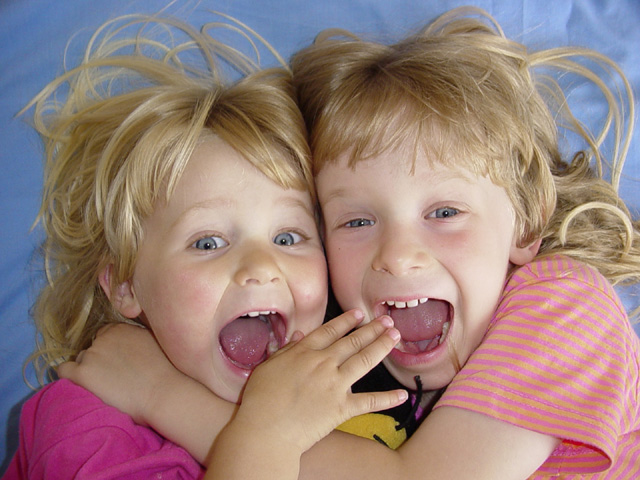

In [69]:
import tensorflow as tf
import PIL
from nima.utils import image_utils


image_file = os.path.join(AVA_DATASET_DIR, '10240.jpg')
crop_size=(224,224)
PIL.Image.open(image_file)

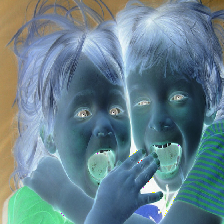

In [117]:
img = image_utils.load_image(image_file, (256, 256,  3))
# img = tf.convert_to_tensor(img)
img = tf.image.random_crop(img, size=(*crop_size, 3))
img = tf.image.random_flip_left_right(img)
img = np.array(img)*255

PIL.Image.fromarray(img.astype(np.uint8)).resize(crop_size)

(256, 256, 3)
(224, 224, 3)


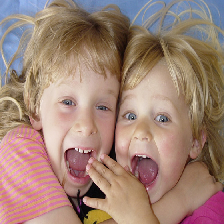

In [121]:
img = image_utils.load_image(image_file, (256, 256,  3))
print(img.shape)
img = image_utils.random_crop_image(img, crop_size)
if (np.random.random() > 0.5) and True: 
    img = np.fliplr(img)

print(img.shape)
PIL.Image.fromarray(img.astype(np.uint8))